# We want to run a check with and without binaries turned on in TRILEGAL

We'll do this without a covariance matrix.

In [1]:
# !/bin/env python
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
sns.set_palette('colorblind')
matplotlib.rc('xtick', labelsize=15)
matplotlib.rc('ytick', labelsize=15)
matplotlib.rc('axes',labelsize=15)
matplotlib.rcParams['text.usetex'] = False

import pandas as pd
import pystan
import corner

import pickle
import glob

import os
import sys

__datdir__ = os.path.expanduser('~')+'/PhD/Gaia_Project/data/TRILEGAL/'


In [2]:
nocov = '''
functions {
    real bailerjones_lpdf(real r, real L){
        return log((1/(2*L^3)) * (r*r) * exp(-r/L));
    }
}
data {
    int<lower = 0> N;
    vector[N] m;
    vector<lower=0>[N] m_err;
    vector[N] oo;
    vector<lower=0>[N] oo_err;
    vector<lower=0>[N] RlEbv;

    real oozp_init;
    real oozp_spread;
    real muH;
}
parameters {
    //Hyperparameters
    real mu;
    real<lower=0.> sigma;
    real<lower=1.> sigo;
    real<lower=0.5,upper=1.> Q;
    real<lower=.1, upper=4000.> L;
    real oo_zp;

    //Latent parameters
    vector[N] M_infd_std;
    vector[N] Ai;
    vector<lower = 1.>[N] r_infd;
}
transformed parameters{
    //Inferred and transformed parameters
    vector[N] M_infd;

    //Operations
    for (n in 1:N){
        M_infd[n] = mu + sigma * M_infd_std[n]; //Rescale the M fit
    }
}
model {
    //Define calculable properties
    vector[N] m_true;
    vector[N] oo_true;

    //Hyperparameters [p(theta_rc, L)]
    mu ~ normal(muH, 1.0); // Prior from seismo
    sigma ~ normal(0.0, 1.0);
    Q ~ normal(1., .25);
    sigo ~ normal(3.0, 1.0);
    L ~ uniform(0.1, 4000.);   // Prior on the length scale
    oo_zp ~ normal(oozp_init, oozp_spread); // Prior on the offset (in mu as)

    //Latent parameters [p(alpha_i | theta_rc, L)]
    Ai ~ normal(RlEbv, 0.05);
    for (n in 1:N){
        r_infd[n] ~ bailerjones(L);
        target += log_mix(Q,
            normal_lpdf(M_infd_std[n] | 0., 1.),
            normal_lpdf(M_infd_std[n] | 0., sigo));
    }

    //Calculable properties
    for (n in 1:N){
        m_true[n] = M_infd[n] + 5*log10(r_infd[n]) - 5 + Ai[n];
        oo_true[n] = (1000./r_infd[n]) + (oo_zp/1000.);
    }

    //Observables [p(D | theta_rc, L, alpha)]
    oo ~ normal(oo_true, oo_err);
    m ~ normal(m_true, m_err); //Measurement uncertainty on magnitude
}

'''
sm = pystan.StanModel(model_code = nocov, model_name='nocov')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL nocov_1388c4aa6535899f63f2c3ccb5867a25 NOW.


## Lets have a look at the data

In [3]:
yb = pd.read_csv(__datdir__+'yesbinaries.txt', sep='\s+')[:-1]
yb['mg_err'] = np.ones(len(yb)) * 10e-3
yb['mg'] = np.random.randn(len(yb)) * yb['mg_err'] + yb['G']
yb['Mg'] = yb['mg'] - yb['m-M0']

nb = pd.read_csv(__datdir__+'nobinaries.txt', sep='\s+')[:-1]
nb['mg_err'] = np.ones(len(nb)) * 10e-3
nb['mg'] = np.random.randn(len(nb)) * nb['mg_err'] + nb['G']
nb['Mg'] = nb['mg'] - nb['m-M0']

In [4]:
yb['d'] = 10**((yb['m-M0'] + 5)/5)
yb['oo'] = 1000/yb['d']
nb['d'] = 10**((nb['m-M0'] + 5)/5)
nb['oo'] = 1000/nb['d']

In [38]:
yb[cutyb]

,#Gc,logAge,[M/H],m_ini,logL,logTe,logg,m-M0,Av,m2/m1,...,G,G_BPbr,G_BPft,G_RP,Mact,mg_err,mg,Mg,d,oo
44,1,7.67,0.01,2.66674,1.716,4.045,4.274,9.0,0.0,0.85,...,9.368,9.342,9.335,9.415,2.667,0.01,9.377598,0.377598,630.957344,1.584893
47,1,7.69,0.31,3.41658,2.126,4.095,4.170,8.0,0.0,0.00,...,8.113,8.056,8.041,8.214,3.417,0.01,8.106017,0.106017,398.107171,2.511886
49,1,7.71,0.13,2.88978,1.840,4.055,4.223,10.3,0.0,0.00,...,10.938,10.898,10.888,11.011,2.890,0.01,10.936060,0.636060,1148.153621,0.870964
93,1,7.97,0.01,2.36392,1.528,4.007,4.258,7.9,0.0,0.89,...,8.513,8.505,8.503,8.528,2.364,0.01,8.503064,0.603064,380.189396,2.630268
98,1,7.99,-0.11,2.32174,1.525,4.016,4.288,10.6,0.0,0.81,...,11.379,11.374,11.371,11.390,2.322,0.01,11.379302,0.779302,1318.256739,0.758578
107,1,8.03,-0.09,3.07669,2.023,4.085,4.189,9.5,0.0,0.00,...,9.856,9.806,9.793,9.944,3.077,0.01,9.872247,0.372247,794.328235,1.258925
109,1,8.05,0.19,2.52119,1.618,4.003,4.181,10.5,0.0,0.81,...,10.980,10.979,10.978,10.982,2.521,0.01,10.985499,0.485499,1258.925412,0.794328
115,1,8.09,0.05,2.57200,1.679,4.022,4.204,10.5,0.0,0.00,...,11.388,11.362,11.356,11.435,2.572,0.01,11.394599,0.894599,1258.925412,0.794328
125,1,8.15,-0.23,2.96068,2.010,4.086,4.188,9.6,0.0,0.00,...,10.002,9.953,9.940,10.090,2.961,0.01,9.993228,0.393228,831.763771,1.202264
129,1,8.15,0.27,2.13658,1.325,3.954,4.204,11.4,0.0,0.97,...,12.170,12.195,12.199,12.128,2.137,0.01,12.155857,0.755857,1905.460718,0.524807


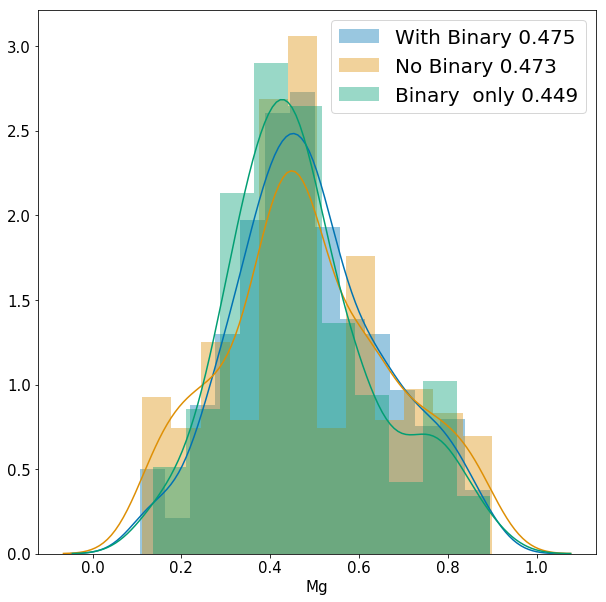

In [47]:
fig = plt.figure(figsize=(10,10))
cutyb = (yb.Mg > 0.1) & (yb.Mg < .9)
cutnb = (nb.Mg > 0.1) & (nb.Mg < .9)

binarity = yb[cutyb]['m2/m1'] > 0.0

sns.distplot(yb.Mg[cutyb], label='With Binary {:.3f}'.format(np.median(yb.Mg[cutyb])))
sns.distplot(nb.Mg[cutnb], label='No Binary {:.3f}'.format(np.median(nb.Mg[cutnb])))
sns.distplot(yb.Mg[cutyb][binarity], label='Binary  only {:.3f}'.format(np.median(yb.Mg[cutyb][binarity])))
plt.legend(fontsize=20)

In [6]:
from omnitool.literature_values import hawkvals

band='GAIA'

pars = ['mu', 'sigma', 'Q', 'sigo', 'L', 'oo_zp']
verbose = [r'$\mu_{RC} (mag)$',r'$\sigma_{RC} (mag)$',r'$Q$', r'$\sigma_o (mag)$', r'$L (pc)$', r'$\varpi_{zp} (\mu as)$']

In [7]:
df = yb[cutyb]

#Correct the Gaia G mags as per Casagrande & Vandenberg 2018b
mband = df['mg']
merr = df['mg_err']
ooerr = df['oo'] * 0.01 #Global 1% error
oo = np.random.randn(len(df))*ooerr + df['oo']
A = df['Av']

dat = {'N':len(df),
        'm': mband,
        'm_err': merr,
        'oo': oo,
        'oo_err': ooerr,
        'RlEbv': A,
        'muH': hawkvals[band],
        'oozp_init' : 0.,
        'oozp_spread' : 1000.}

init= {'mu': hawkvals[band],
        'sigma': 0.1,
        'Q': 0.95,
        'sigo': 4.,
        'L': 1000.,
        'oozp':0.}

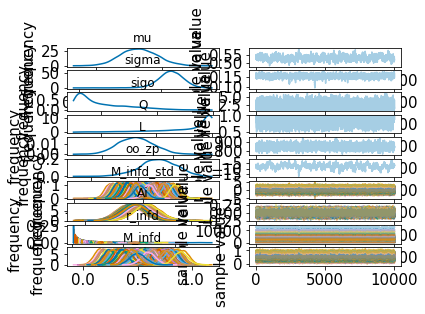

In [8]:
runlabel = __datdir__+band+'_yesbinaries'

fit = sm.sampling(data = dat, iter = 5000, chains=4, seed = 24601,
                    init = [init for i in range(4)])
chain = np.array([fit[label] for label in pars])
np.savetxt(runlabel+'_chains.txt', chain)

pardict = {label:np.median(fit[label]) for label in pars}
pardict.update({label+'_std':np.std(fit[label]) for label in pars})
pardict = pd.DataFrame.from_dict(pardict, orient='index').T
pardict.to_csv(runlabel+'_pars.csv')

s = fit.summary()
rhat = s['summary'][:,-1]
np.savetxt(runlabel+'_rhats.txt',rhat)

corner.corner(chain.T, labels=verbose,quantiles=[0.16, 0.5, 0.84],show_titles=True, title_kwargs={"fontsize":12})
plt.savefig(runlabel+'_corner.png')
plt.close()

fit.plot()
plt.show()

In [9]:
df = nb[cutnb]

#Correct the Gaia G mags as per Casagrande & Vandenberg 2018b
mband = df['mg']
merr = df['mg_err']
ooerr = df['oo'] * 0.01 #Global 1% error
oo = np.random.randn(len(df))*ooerr + df['oo']
A = df['Av']

dat = {'N':len(df),
        'm': mband,
        'm_err': merr,
        'oo': oo,
        'oo_err': ooerr,
        'RlEbv': A,
        'muH': hawkvals[band],
        'oozp_init' : 0.,
        'oozp_spread' : 1000.}

init= {'mu': hawkvals[band],
        'sigma': 0.1,
        'Q': 0.95,
        'sigo': 4.,
        'L': 1000.,
        'oozp':0.}

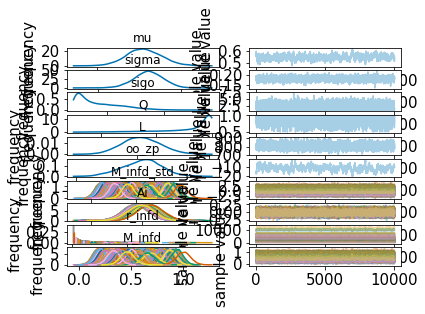

In [10]:
runlabel = __datdir__+band+'_nobinaries'

fit = sm.sampling(data = dat, iter = 5000, chains=4, seed = 24601,
                    init = [init for i in range(4)])
chain = np.array([fit[label] for label in pars])
np.savetxt(runlabel+'_chains.txt', chain)

pardict = {label:np.median(fit[label]) for label in pars}
pardict.update({label+'_std':np.std(fit[label]) for label in pars})
pardict = pd.DataFrame.from_dict(pardict, orient='index').T
pardict.to_csv(runlabel+'_pars.csv')

s = fit.summary()
rhat = s['summary'][:,-1]
np.savetxt(runlabel+'_rhats.txt',rhat)

corner.corner(chain.T, labels=verbose,quantiles=[0.16, 0.5, 0.84],show_titles=True, title_kwargs={"fontsize":12})
plt.savefig(runlabel+'_corner.png')
plt.close()

fit.plot()
plt.show()

In [11]:
pardict

,sigo_std,Q,mu_std,oo_zp,L,sigo,mu,Q_std,L_std,oo_zp_std,sigma,sigma_std
0,0.960892,0.977342,0.017326,-11.441731,806.15678,1.761124,0.54545,0.102092,27.127182,2.556933,0.180413,0.008944


In [12]:
test = pd.read_csv(__datdir__+'GAIA_yesbinaries_pars.csv')
test

,Unnamed: 0,sigo_std,Q,mu_std,oo_zp,L,sigo,mu,Q_std,L_std,oo_zp_std,sigma,sigma_std
0,0,0.934841,0.974445,0.013825,-7.787471,847.570447,1.650313,0.532562,0.108498,24.619588,2.02009,0.155905,0.007835


In [60]:
muwithout = 0.54545
muwith    = 0.532562

print('With no binaries: {:.3f} mag'.format(muwithout))
print('With binaries: {:.3f} mag'.format(muwith))
print('Binaires included in the inlier population causes a shift of: {:.3f} mag'.format(muwithout-muwith))

print(muwithout-muwith)
print('This is roughly half of the shift we need to observe')
print('However coupled with the increased uncertainty... this might just do it')

With no binaries: 0.545 mag
With binaries: 0.533 mag
Binaires included in the inlier population causes a shift of: 0.013 mag
0.012888
This is roughly half of the shift we need to observe
However coupled with the increased uncertainty... this might just do it


In [59]:
ffpars = pd.read_csv('/home/oliver/PhD/Gaia_Project/Output/Parallax_Runs/Testruns/GAIA_fullframe_pars.csv')
scpars = pd.read_csv('/home/oliver/PhD/Gaia_Project/Output/Parallax_Runs/Testruns/GAIA_Uninformed_pars.csv')
ncpars = pd.read_csv('/home/oliver/PhD/Gaia_Project/Output/Parallax_Runs/Testruns/GAIA_nocov_pars.csv')
ffmu = np.float(ffpars['mu'].values[0])
ncmu = np.float(ncpars['mu'].values[0])
scmu = np.float(scpars['mu'].values[0])
print('With expanded covariance function: {:.3f} mag'.format(ffmu))
print('With original covariance function: {:.3f} mag'.format(scmu))
print('With no covariance function: {:.3f} mag'.format(ncmu))
print('Implied shift due to including covariance noise terms: {:.3f} mag'.format(ncmu-ffmu))

With expanded covariance function: 0.521 mag
With original covariance function: 0.546 mag
With no covariance function: 0.546 mag
Implied shift due to including covariance noise terms: 0.025 mag


In [50]:
1565/285 * 0.0003

0.0014999999999999998

In [51]:
print('At a glance, the differences incurred by an increase in uncertainty AND inclusion of binaries is:')
print('Diff: {} mag (G)'.format((muwithout-muwith)+(ncmu -ffmu)))

At a glance, the differences incurred by an increase in uncertainty AND inclusion of binaries is:
Diff: 0.0377272395387 mag (G)
